In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import nltk
from nltk.corpus import stopwords
from numpy import array

from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dropout, Dense
from keras.layers import Flatten, GlobalMaxPooling1D, Embedding, Conv1D, LSTM
from sklearn.model_selection import train_test_split

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
df = pd.read_csv("/content/drive/MyDrive/project data/output.csv")

##Peforming EDA

In [6]:
df.head()

,Unnamed: 0,Text,Emotion
0,0,i didnt feel humiliated,sadness
1,1,i can go from feeling so hopeless to so damned...,sadness
2,2,im grabbing a minute to post i feel greedy wrong,anger
3,3,i am ever feeling nostalgic about the fireplac...,love
4,4,i am feeling grouchy,anger


In [7]:
df.shape

(222450, 3)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 222450 entries, 0 to 222449
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  222450 non-null  int64 
 1   Text        222450 non-null  object
 2   Emotion     222450 non-null  object
dtypes: int64(1), object(2)
memory usage: 5.1+ MB


In [9]:
df.isnull().sum()

Unnamed: 0    0
Text          0
Emotion       0
dtype: int64

In [10]:
df.duplicated().sum()

16000

In [11]:
df.drop_duplicates(inplace=True)

In [12]:
df.head()

,Unnamed: 0,Text,Emotion
0,0,i didnt feel humiliated,sadness
1,1,i can go from feeling so hopeless to so damned...,sadness
2,2,im grabbing a minute to post i feel greedy wrong,anger
3,3,i am ever feeling nostalgic about the fireplac...,love
4,4,i am feeling grouchy,anger


<Axes: xlabel='Emotion'>

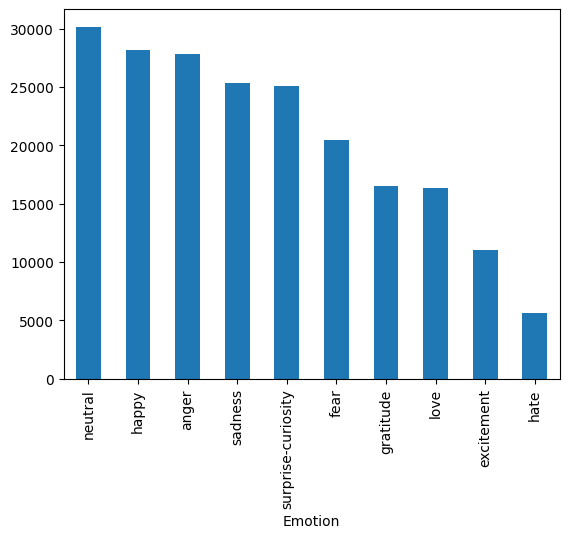

In [13]:
df["Emotion"].value_counts().plot(kind="bar")

##Data Preprocessing

In [14]:
df["Text"][10]

'i feel like i have to make the suffering i m seeing mean something'

In [15]:
TAG_RE = re.compile(r'<[^>]+')

def remove_tags(text):
  """Removes HTML tags: replaces anything between opening and closing  <> with empty space """

  return TAG_RE.sub('',text)

In [16]:
import nltk
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [17]:
def preprocsses_text(sen):
  """Cleans text data up, leaving only 2 or more char long non-stepwords composed of A-Z & a-z only in lowercase"""

  sentence = sen.lower()

  #Removing html tags
  sentence = remove_tags(sentence)

  #Removing punctuations and numbers
  sentence = re.sub('[^a-zA-Z]', ' ' , sentence)

  #Single Character removal
  sentence = re.sub(r"\s+[a-zA-Z]\s+" , ' ' ,sentence)  # When we remove apostrophe from the word "Mark's , the apostrophe is replaced by an empty space. Hence, we are left with 2 words"

  #Remove multiple spaces
  sentence = re.sub(r'\s+', ' ', sentence) # we remove all the single characters and replace it by a space which create multiple spaces in our text


  #Remove Stopwords
  pattern = re.compile(r'\b(' +r'|'.join(stopwords.words("english")) +r')\b\s*')
  sentence = pattern.sub('',sentence)

  return sentence

  #Removing stopwords
  stop_words = set(stopwords.words('english'))

In [18]:
#Calling the preprocessing_text function on movie_reviews

X = []
sentences = list(df['Text'])
for sen in sentences:
  X.append(preprocsses_text(sen))
X = np.array(X)

In [19]:
# Sample cleaned up movie review

X[10]

# As we shall use Word Embedding, Stemming/Lemmatization is not performed as a preprocessing step here

'feel like make suffering seeing mean something'

In [20]:
# # Converting sentiment labels to 0 and 1

# y = df['sentiment']

# y = np.array(list(map(lambda x: 1 if x=="positive" else 0,y)))

from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

y = label_encoder.fit_transform(df['Emotion'])

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2, random_state=42)

##Preparing Embedding layer

Let's now write the script for our embedding layer. Embedding layer convert our textual data into numeric form. It us then used as the first layer for the deep learning models in Keras.

In [22]:
#Embedding layer expects the words to be in numeric form
#using Toekenizer function from keras.preprocessing.text library
#Method fit_on_text trains the tokenizer
#Method texts_to_sequences converts sentences to their numeric form

max_words = 10000
word_tokenizer = Tokenizer(num_words=max_words)
word_tokenizer.fit_on_texts(X_train)

X_train = word_tokenizer.texts_to_sequences(X_train)
X_test = word_tokenizer.texts_to_sequences(X_test)

In [23]:
#Adding 1 to store dimensions for words for which no pretrained word embedding exist
#Total unique words in the corpus
vocab_length = len(word_tokenizer.word_index) +1
vocab_length

73595

In [24]:
# Padding all reviews to fixed length 100

maxlen = 100
X_train = pad_sequences(X_train,padding="post",maxlen=maxlen)
X_test = pad_sequences(X_test,padding="post",maxlen=maxlen)

In [26]:
#Load GloVe word Embeddings and create an Embeddings Dictionary

from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()
glove_file = open("/content/drive/MyDrive/project data/a2_glove.6B.100d.txt",encoding="utf8")

for line in glove_file:
  records = line.split()
  word = records[0]
  vector_dimensions = asarray(records[1:],dtype="float32")
  embeddings_dictionary[word] = vector_dimensions
glove_file.close()

In [27]:
# Create Embedding Matrix having 100 columns
# Containing 100-dimendsional GloVe word embeddings for all words in our corpus

embedding_matrix = zeros((vocab_length,100))
for word,index in word_tokenizer.word_index.items():
  embedding_vector = embeddings_dictionary.get(word)
  if embedding_vector is not None:
    embedding_matrix[index] = embedding_vector

In [28]:
embedding_matrix.shape

(73595, 100)

In [29]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, BatchNormalization

# Initialize the LSTM model
lstm_model = Sequential()

# Add Embedding layer
# embedding_layer = Embedding(input_dim = max_words,output_dim=100,input_length=maxlen)
embedding_layer = Embedding(vocab_length,100,weights=[embedding_matrix],input_length=maxlen,trainable=True)
lstm_model.add(embedding_layer)

# Add LSTM layers with BatchNormalization and Dropout
lstm_model.add(LSTM(units = 128, return_sequences=True))
lstm_model.add(BatchNormalization())
lstm_model.add(Dropout(0.2))

# Add another LSTM layer with BatchNormalization and Dropout
lstm_model.add(LSTM(64, return_sequences=True))
lstm_model.add(BatchNormalization())
lstm_model.add(Dropout(0.2))

# Add another LSTM layer with BatchNormalization and Dropout
lstm_model.add(LSTM(64))
lstm_model.add(BatchNormalization())
lstm_model.add(Dropout(0.2))

# Add Dense layer with ReLU activation and BatchNormalization
lstm_model.add(Dense(128, activation="relu"))
lstm_model.add(BatchNormalization())

# Add Dropout for regularization
lstm_model.add(Dropout(0.2))

lstm_model.add(Dense(64, activation="relu"))
lstm_model.add(BatchNormalization())

# Add Dropout for regularization
lstm_model.add(Dropout(0.2))

# Add output layer with softmax activation
lstm_model.add(Dense(10, activation="softmax"))

In [30]:
# Model Compiling
from tensorflow.keras.optimizers import Adam
learning_rate = 0.001
optimizer = Adam(learning_rate=learning_rate)
lstm_model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [31]:
lstm_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 100)          7359500   
                                                                 
 lstm (LSTM)                 (None, 100, 128)          117248    
                                                                 
 batch_normalization (Batch  (None, 100, 128)          512       
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 100, 128)          0         
                                                                 
 lstm_1 (LSTM)               (None, 100, 64)           49408     
                                                                 
 batch_normalization_1 (Bat  (None, 100, 64)           256       
 chNormalization)                                       

In [38]:
# Model Training

lstm_model_record = lstm_model.fit(X_train,y_train,batch_size=64,epochs=20,validation_split=0.2)

Epoch 1/20
2065/2065 [==============================] - 46s 22ms/step - loss: 0.7950 - accuracy: 0.7399 - val_loss: 2.1652 - val_accuracy: 0.4627
Epoch 2/20
2065/2065 [==============================] - 46s 22ms/step - loss: 0.7710 - accuracy: 0.7457 - val_loss: 2.0385 - val_accuracy: 0.4614
Epoch 3/20
2065/2065 [==============================] - 47s 23ms/step - loss: 0.7486 - accuracy: 0.7517 - val_loss: 2.1313 - val_accuracy: 0.4652
Epoch 4/20
2065/2065 [==============================] - 46s 22ms/step - loss: 0.7239 - accuracy: 0.7595 - val_loss: 2.1056 - val_accuracy: 0.4622
Epoch 5/20
2065/2065 [==============================] - 46s 22ms/step - loss: 0.7083 - accuracy: 0.7627 - val_loss: 2.2666 - val_accuracy: 0.4629
Epoch 6/20
2065/2065 [==============================] - 46s 22ms/step - loss: 0.6849 - accuracy: 0.7686 - val_loss: 2.2477 - val_accuracy: 0.4576
Epoch 7/20
2065/2065 [==============================] - 46s 22ms/step - loss: 0.6648 - accuracy: 0.7734 - val_loss: 2.4427 -

In [33]:
# Predictions on the Test data

score = lstm_model.evaluate(X_test,y_test)

1291/1291 [==============================] - 10s 8ms/step - loss: 2.1543 - accuracy: 0.4511


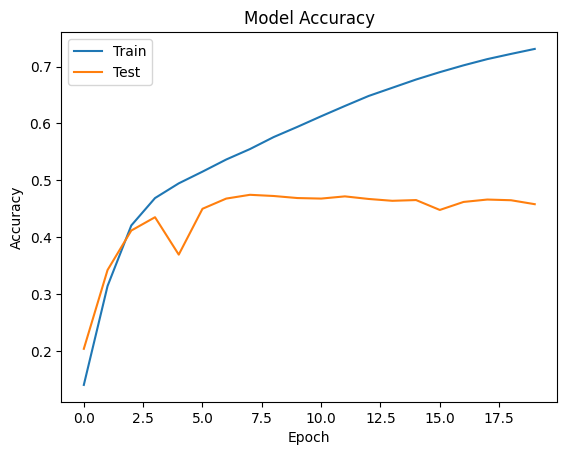

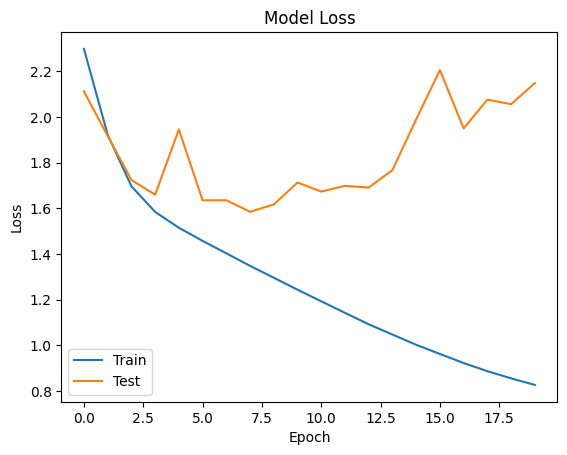

In [34]:
# Model Performance Charts

plt.plot(lstm_model_record.history["accuracy"])
plt.plot(lstm_model_record.history["val_accuracy"])

plt.title("Model Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Train","Test"])
plt.show()

plt.plot(lstm_model_record.history["loss"])
plt.plot(lstm_model_record.history["val_loss"])

plt.title("Model Loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Train","Test"])
plt.show()

In [35]:
import plotly.graph_objs as go

In [36]:
def sentiment_analysis_barchart(input_text, model, tokenizer, label_encoder):
    # Tokenize and pad input text
    sequence = tokenizer.texts_to_sequences([input_text])
    sequence_padded = pad_sequences(sequence, maxlen=maxlen)

    # Predict probabilities for each label
    predictions = model.predict(sequence_padded)[0]

    # Decode label predictions
    labels = label_encoder.classes_

    # Create bar chart
    data = [go.Bar(x=labels, y=predictions)]
    layout = go.Layout(title='Emotion Prediction Bar Chart', xaxis=dict(title='Emotions'), yaxis=dict(title='Probability'))
    fig = go.Figure(data=data, layout=layout)
    fig.show()


In [37]:
# Test the function
input_text = "happy for you"
input_text = preprocsses_text(input_text)
sentiment_analysis_barchart(input_text, lstm_model, word_tokenizer, label_encoder)

1/1 [==============================] - 1s 1s/step
